In [1]:
import glob
import os
import time
import csv

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID' 
os.environ['CUDA_VISIBLE_DEVICES']='1'

# from tqdm import tnrange, tqdm_notebook
from tqdm import tqdm

# from skimage.transform import resize
# from skimage import data, color

import keras.backend as K
from keras.activations import relu
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Reshape, Flatten, Dropout,BatchNormalization,Activation,PReLU,LeakyReLU, Add, Lambda
from keras.layers import UpSampling2D, Conv2D, MaxPooling2D, Conv2DTranspose, GlobalAveragePooling2D, ZeroPadding2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

# from tensorflow.keras.optimizers import Adam,RMSprop
from keras import initializers
from keras.models import load_model
from keras.optimizers import Adam,RMSprop

from keras.utils import multi_gpu_model
# from keras.utils import HDF5Matrix

from keras.preprocessing.image import ImageDataGenerator

# from tensorflow.keras.datasets import mnist
from keras.utils import to_categorical

import tensorflow as tf
# from tensorflow.python.keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.utils import shuffle

# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

Using TensorFlow backend.


In [2]:
def load_data():
    x_train = (h5py.File('camelyonpatch_level_2_split_train_x.h5', 'r')['x'][:, 16:80,16:80] - 127.5) / 127.5
    y_train = h5py.File('camelyonpatch_level_2_split_train_y.h5', 'r')['y'][:].reshape(-1,1)
    x_test = (h5py.File('camelyonpatch_level_2_split_test_x.h5', 'r')['x'][:, 16:80,16:80] - 127.5) / 127.5
    y_test = h5py.File('camelyonpatch_level_2_split_test_y.h5', 'r')['y'][:].reshape(-1,1)
    x_valid = (h5py.File('camelyonpatch_level_2_split_valid_x.h5', 'r')['x'][:, 16:80,16:80] - 127.5) / 127.5
    y_valid = h5py.File('camelyonpatch_level_2_split_valid_y.h5', 'r')['y'][:].reshape(-1,1)
              
    return x_train, y_train, x_test, y_test, x_valid, y_valid

def plot_samples(samples, folder=None, epoch=None):
    rt = int(np.sqrt(samples.shape[0]))
    r, c = rt, rt
    generatedImage = 0.5 * samples + 0.5

    fig = plt.figure(figsize=(10,10))

    axs = [fig.add_subplot(r,c,i+1) for i in range(r*c)]
    cnt = 0
    for ax in axs:
        ax.imshow(generatedImage[cnt],interpolation='nearest')
        ax.axis('off')
        ax.set_aspect('equal')
        cnt+=1
    fig.subplots_adjust(wspace=.008, hspace=.03)

    if folder:
        path = 'results/'+folder+'/samples'
        if not os.path.exists('results'):
            os.mkdir('results')
        if not os.path.exists('results/'+folder):
            os.mkdir('results/'+folder)
        if not os.path.exists(path):
            os.mkdir(path)
        fig.savefig(path+'/epoch_%d.png' % epoch)
        plt.close()


In [15]:
fake = h5py.File('fake.hdf5', 'r')['fake'][:]
fake.shape

(262144, 64, 64, 3)

In [18]:
saved_actor = load_model('results/wgan_gp/models/G_1950.h5')

/usr/local/lib/python3.5/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [23]:
# noise = np.random.normal(0,1,size=(x_train.shape[0], 100))
# imgs = saved_actor.predict(noise)
# imgs.shape

# with h5py.File("fake.hdf5", "w") as f:
#     f.create_dataset("fake", data=imgs)

(262144, 64, 64, 3)

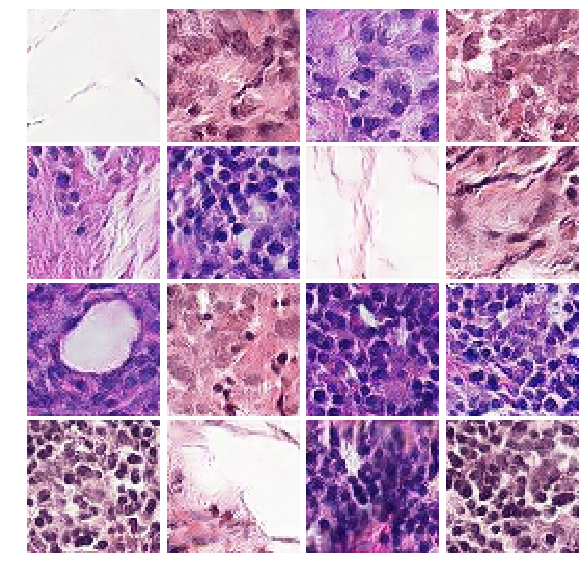

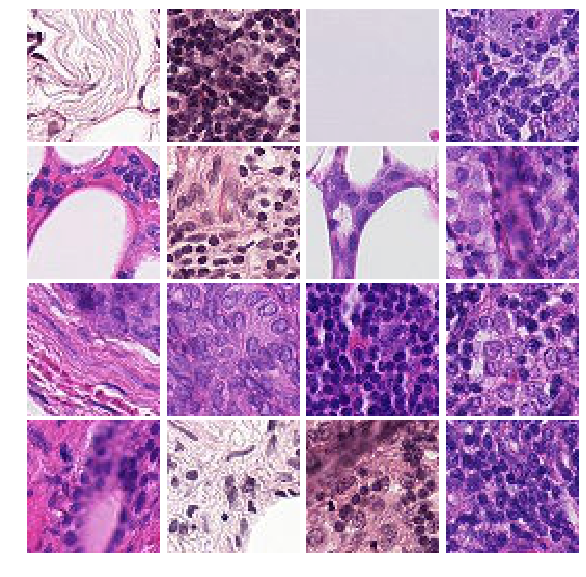

In [21]:
noise = np.random.normal(0,1,size=(16,100))
imgs = saved_actor.predict(noise)

plot_samples(imgs)
plot_samples(x_train[np.random.choice(range(x_train.shape[0]), 16, replace=False)])

26214


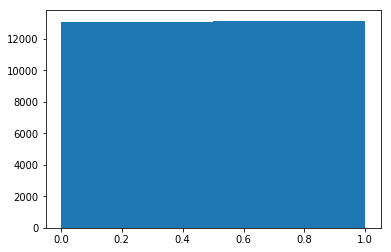

In [3]:
x_train, y_train, x_test, y_test, x_valid, y_valid = load_data()

percent = int(x_train.shape[0]*.1)
np.random.seed(17)
idx_small = np.random.choice(range(x_train.shape[0]), percent, replace=False)

x_train_small = x_train[idx_small]
y_train_small = y_train[idx_small]
plt.hist(y_train_small, bins=2)
print(percent)

In [4]:
# https://github.com/eriklindernoren/Keras-GAN/blob/master/sgan/sgan.py
class SGAN:
    def __init__(self, num_classes, rows, cols, channels, latent_dim=100):
        self.img_rows = rows
        self.img_cols = cols
        self.channels = channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = num_classes
        self.latent_dim = latent_dim

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(
            loss=['binary_crossentropy', 'categorical_crossentropy'],
            loss_weights=[0.5, 0.5],
            optimizer=optimizer,
            metrics=['accuracy']
        )

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        noise = Input(shape=(self.latent_dim,))
        img = self.generator(noise)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid, _ = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model(noise, valid)
        self.combined.compile(loss=['binary_crossentropy'], optimizer=optimizer)

    def build_generator(self):
        model = Sequential()

        model.add(Dense(32*int(self.img_rows/4)*int(self.img_cols/4), input_dim=self.latent_dim))
        model.add(Activation('relu'))
        model.add(Reshape((int(self.img_rows/4),int(self.img_cols/4), 32)))
    #     model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))

        model.add(UpSampling2D(interpolation='nearest'))
        model.add(Conv2D(64, kernel_size=3, strides=1, padding="same"))
        model.add(Activation('relu'))
    #     model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))

        model.add(UpSampling2D(interpolation='nearest'))
        model.add(Conv2D(48, kernel_size=4, strides=2, padding="same"))
        model.add(Activation('relu'))
    #     model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))

        model.add(UpSampling2D(interpolation='nearest'))
        model.add(Conv2D(32, kernel_size=3, strides=1, padding="same"))
        model.add(Activation('relu'))
    #     model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))

        model.add(UpSampling2D(interpolation='nearest'))
        model.add(Conv2D(16, kernel_size=4, strides=2, padding="same"))
        model.add(Activation('relu'))
    #     model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))

        model.add(Conv2D(8, kernel_size=3, strides=1, padding="same"))
        model.add(Activation('relu'))
    #     model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))

        model.add(UpSampling2D(interpolation='nearest'))
        model.add(Conv2D(16, kernel_size=4, strides=2, padding="same"))
        model.add(Activation('relu'))
    #     model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))

        model.add(Conv2D(self.channels, kernel_size=3, strides=1, padding="same"))
        model.add(Activation("tanh"))

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        kernel_size = 4
        model = Sequential()

        model.add(Conv2D(32, kernel_size=kernel_size, strides=2, 
                         input_shape=(self.img_rows, self.img_cols, self.channels), padding="same"))
        model.add(LeakyReLU(alpha=0.1))
        model.add(Dropout(0.15))

        model.add(Conv2D(64, kernel_size=kernel_size, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.1))
        model.add(Dropout(0.15))

        model.add(Conv2D(128, kernel_size=kernel_size, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.1))
        model.add(Dropout(0.15))

        model.add(Flatten())

        img = Input(shape=self.img_shape)

        features = model(img)
        valid = Dense(1, activation="sigmoid")(features)
        label = Dense(self.num_classes+1, activation="softmax")(features)

        return Model(img, [valid, label])

    def train(self, X_train, y_train, epochs, batch_size=128, sample_interval=50):
        # Class weights:
        # To balance the difference in occurences of digit class labels.
        # 50% of labels that the discriminator trains on are 'fake'.
        # Weight = 1 / frequency
        half_batch = batch_size // 2
        cw1 = {0: 1, 1: 1}
        cw2 = {i: self.num_classes / half_batch for i in range(self.num_classes)}
        cw2[self.num_classes] = 1 / half_batch

        # Adversarial ground truths

        val_labels = [np.ones((y_valid.shape[0], 1)), to_categorical(y_valid, num_classes=self.num_classes+1)]

        DLoss = []
        GLoss = []
        Acc = []
        AccOp = []
        LossVal = []
        AccVal = []
        AccOpVal = []
        for epoch in range(epochs):
            d_loss = []
            acc = []
            acc_op= []
            g_loss = []
            for idx in tqdm(np.array_split(shuffle(range(X_train.shape[0])), X_train.shape[0]/batch_size), desc="epoch "+str(epoch)):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                imgs = X_train[idx]

                # Sample noise and generate a batch of new images
                noise = np.random.normal(0, 1, (idx.shape[0], self.latent_dim))
                gen_imgs = self.generator.predict(noise)

                # One-hot encoding of labels
                labels = to_categorical(y_train[idx], num_classes=self.num_classes+1)
                fake_labels = to_categorical(np.full((idx.shape[0], 1), self.num_classes), num_classes=self.num_classes+1)

                valid = np.ones((idx.shape[0], 1))
                fake = np.zeros((idx.shape[0], 1))                
                # Train the discriminator
                d_loss_real = self.discriminator.train_on_batch(imgs, [valid, labels], class_weight=[cw1, cw2])
                d_loss_fake = self.discriminator.train_on_batch(gen_imgs, [fake, fake_labels], class_weight=[cw1, cw2])
                metrics = 0.5 * np.add(d_loss_real, d_loss_fake)
                d_loss.append(metrics[0])
                acc.append(metrics[3])
                acc_op.append(metrics[4])

                # ---------------------
                #  Train Generator
                # ---------------------

                g_loss.append(self.combined.train_on_batch(noise, valid, class_weight=[cw1, cw2]))

            # Plot the progress
            d_loss_mean = sum(d_loss)/len(d_loss)
            g_loss_mean = sum(g_loss)/len(g_loss)
            acc_mean = sum(acc)/len(acc)
            acc_op_mean = sum(acc_op)/len(acc_op)
            g_loss_mean = sum(g_loss)/len(g_loss)

            print ("Dloss: %f, acc: %.4f, op_acc: %.4f, Gloss: %f" % (d_loss_mean, acc_mean, acc_op_mean, g_loss_mean))
            
            DLoss.append(d_loss_mean)
            GLoss.append(g_loss_mean)
            Acc.append(acc_mean)
            AccOp.append(acc_op_mean)
            
            val = self.discriminator.evaluate(x_valid, val_labels, verbose=0)
            LossVal.append(val[0])
            AccVal.append(val[3])
            AccOpVal.append(val[4])
            print ("loss: %f, acc: %.4f, op_acc: %.4f" % (val[0], val[3], val[4]))

            # If at save interval => save generated image samples
#             if epoch % sample_interval == 0:
            self.sample_images('sgan', epoch)
        return DLoss, GLoss, Acc, AccOp, LossVal, AccVal, AccOpVal

    def sample_images(self, folder, epoch):
        r, c = 4, 4
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        generatedImage = 0.5 * self.generator.predict(noise) + 0.5
        
        fig = plt.figure(figsize=(10,10))
        
        axs = [fig.add_subplot(r,c,i+1) for i in range(r*c)]
        cnt = 0
        for ax in axs:
            ax.imshow(generatedImage[cnt],interpolation='nearest')
            ax.axis('off')
            ax.set_aspect('equal')
            cnt+=1
        fig.subplots_adjust(wspace=.008, hspace=.03)
    
        path = 'results/'+folder+'/samples'
        if not os.path.exists('results'):
            os.mkdir('results')
        if not os.path.exists('results/'+folder):
            os.mkdir('results/'+folder)
        if not os.path.exists(path):
            os.mkdir(path)
        fig.savefig(path+'/epoch_%d.png' % epoch)
        plt.close()

    def save_model(self):

        def save(model, model_name):
            model_path = "saved_model/%s.json" % model_name
            weights_path = "saved_model/%s_weights.hdf5" % model_name
            options = {"file_arch": model_path,
                        "file_weight": weights_path}
            json_string = model.to_json()
            open(options['file_arch'], 'w').write(json_string)
            model.save_weights(options['file_weight'])

        save(self.generator, "mnist_sgan_generator")
        save(self.discriminator, "mnist_sgan_discriminator")
        save(self.combined, "mnist_sgan_adversarial")


In [ ]:
sgan = SGAN(2, 64, 64, 3)
DLoss, GLoss, Acc, AccOp, LossVal, AccVal, AccOpVal = sgan.train(x_train_small, y_train_small, epochs=10000)

In [26]:
# https://machinelearningmastery.com/semi-supervised-generative-adversarial-network/
# https://github.com/cympfh/GAN-semisup-MNIST-Keras

class ImprovedSGAN:
    def __init__(self, width, height, channels, num_labels, model_name, latent_dim=100):
        self.width=width
        self.height=height
        self.channels=channels
        self.num_labels=num_labels
        self.model_name = model_name
        self.latent_dim = latent_dim

        self.classifier, self.discriminator, self.generator, self.gan = self.build()
#         self.discriminator, self.classifier = define_discriminator()
#         self.generator = define_generator(latent_dim)
#         self.gan = define_gan(self.generator, self.discriminator)
        
    def build_conv(self):
        model = Sequential(name='conv')
        model.add(Conv2D(32, kernel_size=4, strides=2, input_shape=(self.width, self.height, self.channels), padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.2))

        model.add(Conv2D(64, kernel_size=4, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2D(128, kernel_size=4, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.5))

        model.add(Flatten())

        model.add(Dense(self.num_labels))
        return model


    def build_classifier(self, conv):
        model = Sequential(name='classifier')
        model.add(conv)
        model.add(Activation('softmax'))
        return model

    def build_discriminator(self, conv):
        model = Sequential(name='discriminator')
        model.add(conv)

        def predict1(output):
            logexpsum = K.sum(K.exp(output), axis=-1, keepdims=True)
            result = logexpsum / (logexpsum + 1.0)
            return result

        def predict(y):
            p = 1.0 - (1.0 / (K.sum(K.exp(y), axis=-1, keepdims=True) + 1.0))
            return p

        model.add(Lambda(predict))

        return model

    def build_gen(self):
        model = Sequential(name='generator')

        model.add(Dense(128*self.width//4*self.height//4, input_dim=self.latent_dim))
    #     model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))
        model.add(Activation('relu'))
        model.add(Reshape((self.width//4, self.height//4, 128)))

        model.add(UpSampling2D(interpolation='nearest'))
        model.add(Conv2D(64, kernel_size=3, strides=1, padding="same"))
    #     model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))
        model.add(Activation('relu'))

        model.add(UpSampling2D(interpolation='nearest'))
        model.add(Conv2D(32, kernel_size=4, strides=2, padding="same"))
    #     model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))
        model.add(Activation('relu'))

        model.add(UpSampling2D(interpolation='nearest'))
        model.add(Conv2D(16, kernel_size=3, strides=1, padding="same"))
    #     model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))
        model.add(Activation('relu'))

        model.add(UpSampling2D(interpolation='nearest'))
        model.add(Conv2D(16, kernel_size=4, strides=2, padding="same"))
    #     model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))
        model.add(Activation('relu'))

        model.add(Conv2D(4, kernel_size=3, strides=1, padding="same"))
    #     model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))
        model.add(Activation('relu'))

#         model.add(UpSampling2D(interpolation='nearest'))
#         model.add(Conv2D(16, kernel_size=4, strides=2, padding="same"))
#     #     model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))
#         model.add(Activation('relu'))

        model.add(Conv2D(self.channels, kernel_size=3, strides=1, padding="same"))
        model.add(Activation("tanh"))

        return model


    def build_gan(self, gen, dis):
        model = Sequential(name='gan')
        model.add(gen)
        model.add(dis)
        return model


    def build(self):

        conv = self.build_conv()
        clf = self.build_classifier(conv)
        dis = self.build_discriminator(conv)
        gen = self.build_gen()

#         opt = Adam(clipvalue=1.0, lr=0.0002, beta_1=0.5)
#         opt_weak = Adam(clipvalue=0.1, lr=0.0001)

        lr = 0.0002
        opt = Adam(lr=lr)
        opt_weak = Adam(lr=lr)
        clf_loss = 'sparse_categorical_crossentropy'
        clf.compile(loss=clf_loss, metrics=['accuracy'], optimizer=opt_weak)

        dis_loss = 'binary_crossentropy'
        dis.compile(loss=dis_loss, optimizer=opt)

        dis.trainable = False
        gan = self.build_gan(gen, dis)
        gan_loss = 'binary_crossentropy'
        gan.compile(loss=gan_loss, optimizer=opt)

        return clf, dis, gen, gan

    def train(self, epochs, X_train, y_train, X, X_val, y_val, batch_size=28):
        # d_real = np.ones((batch_size, 1))
        # d_fake = np.zeros((batch_size, 1))

        
        g_batch_size = int(batch_size*2)


        self.clf_loss = []
        self.clf_acc = []
        self.clf_loss_val = []
        self.clf_acc_val = []

        self.g_loss = []
        self.d_loss_real=[]
        self.d_loss_fake=[]

#         self.d_acc=[]

        idx_range = np.arange(X_train.shape[0])

        for e in range(epochs):
            clf_loss = []
            clf_acc = []
            g_loss = []
            d_loss_fake = []
            d_loss_real = []
            for idx in np.array_split(shuffle(idx_range), idx_range.shape[0]/(batch_size/2)):
                loss, acc = self.classifier.train_on_batch(X_train[idx], y_train[idx])
                clf_loss.append(loss)
                clf_acc.append(acc)

                self.discriminator.trainable = True
                idx_u = np.random.choice(X.shape[0], idx.shape[0], replace=False)
                d_loss_real.append(self.discriminator.train_on_batch(X[idx_u], np.ones((idx.shape[0], 1))))

                noise = np.random.normal(0, 1, (idx.shape[0], self.latent_dim))
                x_fake = self.generator.predict(noise)
                d_loss_fake.append(self.discriminator.train_on_batch(x_fake, np.zeros((idx.shape[0], 1))))
                self.discriminator.trainable = False

#                 noise = np.concatenate([noise, np.random.normal(0, 1, (idx.shape[0]*5, self.latent_dim))])
                g_loss.append(self.gan.train_on_batch(noise, np.ones((noise.shape[0], 1))))

            loss, acc = self.classifier.evaluate(X_val, y_val, batch_size=batch_size, verbose=0)
            self.clf_loss_val.append(loss)
            self.clf_acc_val.append(acc)
            self.clf_loss.append(sum(clf_loss)/len(clf_loss))
            self.clf_acc.append(sum(clf_acc)/len(clf_acc))
            self.g_loss.append(sum(g_loss)/len(g_loss))
            self.d_loss_real.append(sum(d_loss_real)/len(d_loss_real))
            self.d_loss_fake.append(sum(d_loss_fake)/len(d_loss_fake))
            
            print("D real: %f; D fake %f; G loss %f"%(self.d_loss_real[-1], self.d_loss_fake[-1], self.g_loss[-1]))
            print("Clf Loss: %f; acc: %.2f"%(self.clf_loss[-1], self.clf_acc[-1]))
            print("Val Loss: %f; acc: %.2f"%(loss, acc))

            if e%20==0:
                plot_samples(self.generator.predict(np.random.normal(0, 1, (16, self.latent_dim))), self.model_name, e)


In [24]:
def save_stats(model):
    path = 'results/'+model.model_name
    
    with open(path+'/clf_acc.csv', 'w', newline='') as myfile:
        wr = csv.writer(myfile)
        wr.writerow(model.clf_acc)

    with open(path+'/clf_loss.csv', 'w', newline='') as myfile:
        wr = csv.writer(myfile)
        wr.writerow(model.clf_loss)

    with open(path+'/clf_acc_val.csv', 'w', newline='') as myfile:
        wr = csv.writer(myfile)
        wr.writerow(model.clf_acc_val)

    with open(path+'/clf_loss_val.csv', 'w', newline='') as myfile:
        wr = csv.writer(myfile)
        wr.writerow(model.clf_loss_val)

    with open(path+'/d_loss_fake.csv', 'w', newline='') as myfile:
        wr = csv.writer(myfile)
        wr.writerow(model.d_loss_fake)

    with open(path+'/d_loss_real.csv', 'w', newline='') as myfile:
        wr = csv.writer(myfile)
        wr.writerow(model.d_loss_real)

    with open(path+'/g_loss.csv', 'w', newline='') as myfile:
        wr = csv.writer(myfile)
        wr.writerow(model.g_loss)

def save_plots(model):
    path = 'results/'+model.model_name
    
    fig = plt.figure(figsize=(18,5))
    plt.plot(model.g_loss[::20], label='G')
    plt.plot(model.d_loss_real[::20], label='D real')
    plt.plot(model.d_loss_fake[::20], label='D fake')
    plt.xlabel('Epochs x20')
    plt.ylabel('Loss')
    plt.legend()
    fig.savefig(path+'/gan_loss.png')

    fig = plt.figure(figsize=(18,5))
    plt.plot(model.clf_loss[::20], label='Train')
    plt.plot(model.clf_loss_val[::20], label='Test')
    plt.xlabel('Epochs x20')
    plt.ylabel('Loss')
    plt.legend()
    fig.savefig(path+'/clf_loss.png')

    fig = plt.figure(figsize=(18,5))
    acc_max = np.max(model.clf_acc_val)
    acc_max_e = np.argmax(model.clf_acc_val)
    plt.axhline(y=acc_max, color='k', linestyle='-', alpha=0.2, linewidth=1)
    plt.axvline(x=acc_max_e, color='k', linestyle='-', alpha=0.2, linewidth=1)
    plt.plot(model.clf_acc[::20], label='Train')
    plt.plot(model.clf_acc_val[::20], label='Test')
    plt.xlabel('Epochs ')
    plt.ylabel('Accuracy')
    plt.legend()
    fig.savefig(path+'/clf_acc.png')



In [ ]:
improved_sgan = ImprovedSGAN(64, 64, 3, 2, 'ImprovedSGAN2_10')
improved_sgan.train(3000, x_train_small, y_train_small, x_train, x_test, y_test, 128)
save_stats(improved_sgan)
save_plots(improved_sgan)

D real: 0.019669; D fake 8.487233; G loss 2.371877
Clf Loss: 0.646372; acc: 0.59
Val Loss: 0.693147; acc: 0.50
D real: 0.000000; D fake 15.942385; G loss 0.000000
Clf Loss: 0.693147; acc: 0.50
Val Loss: 0.693147; acc: 0.50


In [3]:
from keras.datasets import mnist

In [4]:
(x_mnist_train, y_mnist_train), (x_mnist_test, y_mnist_test) = mnist.load_data()
x_mnist_train = (x_mnist_train.reshape(-1, 28,28,1)-127.5)/127.5
y_mnist_train = y_mnist_train.reshape(-1, 1)
x_mnist_test = (x_mnist_test.reshape(-1, 28,28,1)-127.5)/127.5
y_mnist_test = y_mnist_test.reshape(-1, 1)

In [5]:
percent = int(x_mnist_train.shape[0]*.01)
np.random.seed(17)
idx_mnist_small = np.random.choice(range(x_mnist_train.shape[0]), percent, replace=False)

x_mnist_small = x_mnist_train[idx_mnist_small]
y_mnist_small = y_mnist_train[idx_mnist_small]
# plt.hist(y_mnist_small, bins=10)
print(percent)

600


In [ ]:
from keras.layers import Conv2DTranspose

if not os.path.exists('results/isgan'):
    os.mkdir('results/isgan')

# custom activation function
def custom_activation(output):
    logexpsum = K.sum(K.exp(output), axis=-1, keepdims=True)
    result = logexpsum / (logexpsum + 1.0)
    return result

# define the standalone supervised and unsupervised discriminator models
def define_discriminator(in_shape=(28,28,1), n_classes=10):
    # image input
    in_image = Input(shape=in_shape)
    # downsample
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(in_image)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # dropout
    fe = Dropout(0.4)(fe)
    # output layer nodes
    fe = Dense(n_classes)(fe)
    # supervised output
    c_out_layer = Activation('softmax')(fe)
    # define and compile supervised discriminator model
    c_model = Model(in_image, c_out_layer)
    c_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])
    # unsupervised output
    d_out_layer = Lambda(custom_activation)(fe)
    # define and compile unsupervised discriminator model
    d_model = Model(in_image, d_out_layer)
    d_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    return d_model, c_model

# define the standalone generator model
def define_generator(latent_dim):
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((7, 7, 128))(gen)
    # upsample to 14x14
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # upsample to 28x28
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # output
    out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
    # define model
    model = Model(in_lat, out_layer)
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect image output from generator as input to discriminator
    gan_output = d_model(g_model.output)
    # define gan model as taking noise and outputting a classification
    model = Model(g_model.input, gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model


def train(g_model, d_model, c_model, gan_model, latent_dim, n_epochs=20, n_batch=100):
#     X_sup, y_sup = select_supervised_samples(dataset)
#     bat_per_epo = int(dataset[0].shape[0] / n_batch)
#     n_steps = bat_per_epo * n_epochs
    half_batch = int(n_batch / 2)
    for i in range(1000):
#         [Xsup_real, ysup_real], _ = generate_real_samples([X_sup, y_sup], half_batch)
        idx_sup = np.random.choice(x_mnist_train.shape[0], half_batch, replace=False)
        Xsup_real, ysup_real = x_mnist_train[idx_sup], y_mnist_train[idx_sup]
        c_loss, c_acc = c_model.train_on_batch(Xsup_real, ysup_real)

#         [X_real, _], y_real = generate_real_samples(dataset, half_batch)
        idx_unsup = np.random.choice(x_mnist_train.shape[0], half_batch, replace=False)
        X_real, y_real = x_mnist_train[idx_sup], np.ones((half_batch, 1))
        d_loss1 = d_model.train_on_batch(X_real, y_real)

#         X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        X_fake = g_model.predict(noise)
        d_loss2 = d_model.train_on_batch(X_fake, np.zeros((half_batch, 1)))

#         X_gan, y_gan = generate_latent_points(latent_dim, n_batch), ones((n_batch, 1))
        X_gan = np.random.normal(0, 1, (n_batch, latent_dim))
        g_loss = gan_model.train_on_batch(X_gan, np.ones((n_batch, 1)))
        # evaluate the model performance every so often
        if i%100 == 0:
            print('>%d, c[%.3f,%.0f], d[%.3f,%.3f], g[%.3f]' % (i+1, c_loss, c_acc*100, d_loss1, d_loss2, g_loss))
            img = g_model.predict(np.random.normal(0, 1, (1, latent_dim))).reshape(28,28)
            plt.figure()
            plt.imshow(img, cmap='gray', vmin=-1, vmax=1)

# size of the latent space
latent_dim = 100
# create the discriminator models
d_model, c_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
# dataset = load_real_samples()
# train model
train(g_model, d_model, c_model, gan_model, latent_dim)

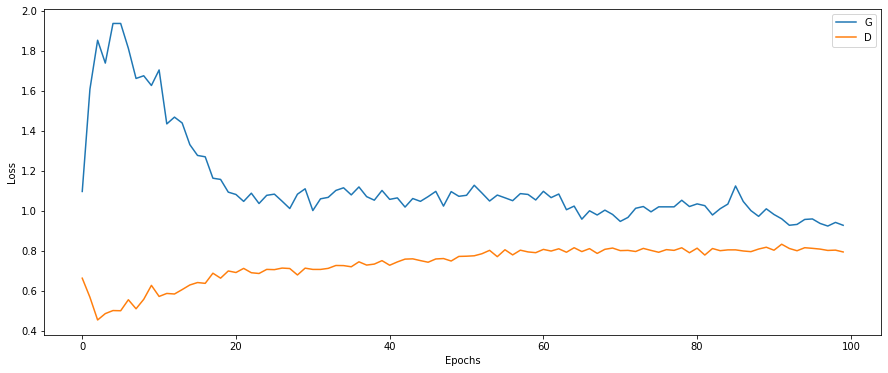

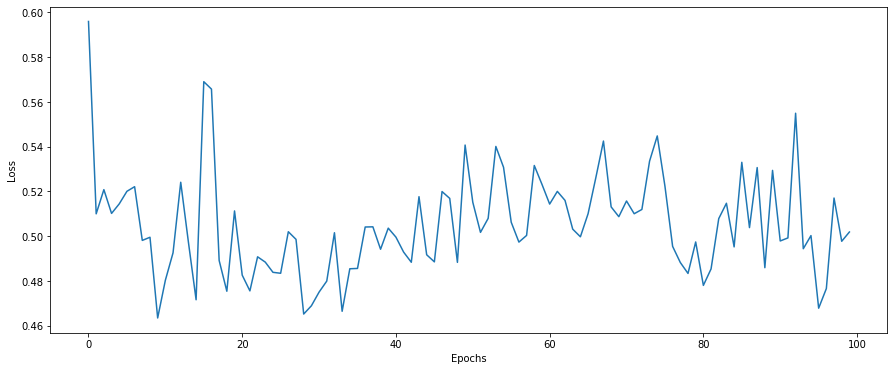

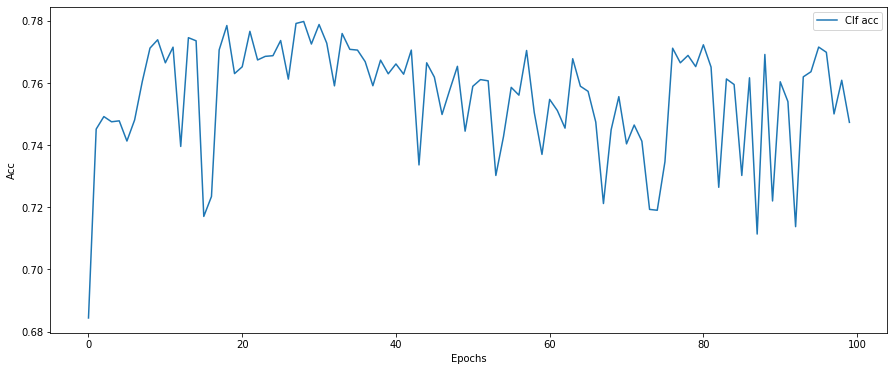

In [28]:
plt.figure(figsize=(15,6))
plt.plot(np.array(g_loss_e), label='G')
plt.plot(np.array(d_loss_e), label='D')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure(figsize=(15,6))
plt.plot(np.array(clf_loss_e), label='acc')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.legend()

plt.figure(figsize=(15,6))
plt.plot(np.array(clf_acc_e), label='Clf acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

In [10]:
# history = classifier.evaluate(x_valid, to_categorical(y_valid, num_classes=num_labels), batch_size=batch_size, verbose=0)
classifier.evaluate(x_valid, y_valid, batch_size=batch_size, verbose=0)

[0.5128703919472173, 0.7358093]

array([[8.1960046e-01, 1.8039960e-01, 7.5936868e-11, 4.3974879e-11,
        7.8478639e-12, 4.8730565e-11, 5.9233840e-11, 5.8512598e-11,
        9.8662870e-11, 1.0967822e-11]], dtype=float32)

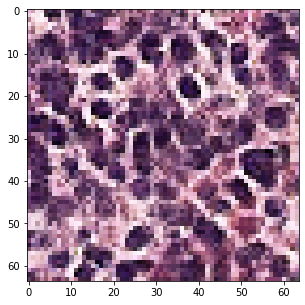

In [24]:
noise = np.random.normal(0, 1, (1, latent_dim))
gen_imgs = generator.predict(noise)
plt.figure(figsize=(5,5))
plt.imshow((gen_imgs[0]* 127.5 + 127.5).astype(np.int))
# plt.imshow(gen_imgs[0])
classifier.predict(gen_imgs)

In [6]:
def create_generic_CNN(width, height, channels):
    kernel_size=3
    model = Sequential()

    model.add(Conv2D(32, kernel_size=kernel_size, input_shape=(width, height, channels), padding="same", activation='elu'))
    model.add(MaxPooling2D(pool_size = 3))
    model.add(BatchNormalization())
    model.add(Dropout(0.15))

    model.add(Conv2D(64, kernel_size=kernel_size, padding="same", activation='elu'))
    model.add(MaxPooling2D(pool_size = 3))
    model.add(BatchNormalization())
    model.add(Dropout(0.15))

    model.add(Conv2D(128, kernel_size=kernel_size, padding="same", activation='elu'))
    model.add(MaxPooling2D(pool_size = 3))
    model.add(BatchNormalization())
    model.add(Dropout(0.15))
    
    return model

def create_CNN(width, height, channels, n_classes=2, gpus=1):

    model = create_generic_CNN(width, height, channels)
    model.add(Flatten())
    model.add(Dense(128, activation='elu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.15))
    
    loss='binary_crossentropy'
    if n_classes == 2:
        model.add(Dense(1, activation='sigmoid'))
    else:
        model.add(Dense(n_classes, activation='softmax'))
        loss = 'categorical_crossentropy'
        
    if gpus!=1:
        model = multi_gpu_model(model, gpus=gpus)
    
    model.compile(loss=loss,optimizer='adam', metrics=['accuracy'])


#     print('Critic')
    model.summary()

    return model

def create_GAP_CNN(width, height, channels, n_classes=2, gpus=8):
    model = create_generic_CNN(width, height, channels)
    
    model.add(GlobalAveragePooling2D())
    
    
    loss='binary_crossentropy'
    if n_classes == 2:
        model.add(Dense(1, activation='sigmoid'))
    else:
        model.add(Dense(n_classes, activation='softmax'))
        loss = 'categorical_crossentropy'
        
    if gpu!=1:
        model = multi_gpu_model(model, gpus=gpus)
    
    model.compile(loss=loss,optimizer='adam', metrics=['accuracy'])

#     print('Critic')
    model.summary()

    return model

def create_SG_G(width, height, channels, latent_dim):

    model = Sequential()
    
    model.add(Dense(32*int(width/4)*int(height/4), input_dim=latent_dim))
    model.add(Activation('relu'))
    model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))
    model.add(Reshape((int(width/4),int(height/4), 32)))

    model.add(UpSampling2D())
#     model.add(UpSampling2D(interpolation='nearest'))
    model.add(Conv2D(64, kernel_size=3, strides=1, padding="same"))
    model.add(Activation('relu'))
    model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))

    model.add(UpSampling2D())
#     model.add(UpSampling2D(interpolation='nearest'))
    model.add(Conv2D(48, kernel_size=4, strides=2, padding="same"))
    model.add(Activation('relu'))
    model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))
    
    model.add(UpSampling2D())
#     model.add(UpSampling2D(interpolation='nearest'))
    model.add(Conv2D(32, kernel_size=3, strides=1, padding="same"))
    model.add(Activation('relu'))
    model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))

    model.add(UpSampling2D())
#     model.add(UpSampling2D(interpolation='nearest'))
    model.add(Conv2D(16, kernel_size=4, strides=2, padding="same"))
    model.add(Activation('relu'))
    model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))
 
    model.add(Conv2D(8, kernel_size=3, strides=1, padding="same"))
    model.add(Activation('relu'))
    model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))

    model.add(UpSampling2D())
#     model.add(UpSampling2D(interpolation='nearest'))
    model.add(Conv2D(16, kernel_size=4, strides=2, padding="same"))
    model.add(Activation('relu'))
    model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))
    
    model.add(Conv2D(channels, kernel_size=3, strides=1, padding="same"))
    model.add(Activation("tanh"))

#     model.summary()

    noise = Input(shape=(latent_dim,))
    img = model(noise)

    return Model(noise, img)

def create_SG_D(width, height, channels):

    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(width, height, channels), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Flatten())

#     model.summary()

    img = Input(shape=(width, height, channels))

    features = model(img)
#     valid = Dense(1, activation="sigmoid")(features)
#     label = Dense(3, activation="softmax")(features)
    valid = Dense(3, activation="softmax")(features)

#     return Model(img, [valid, label])
    return Model(img, valid)

def crate_SGGAN(width, height, channels, latent_dim=128, gpus=8):
        discriminator = create_SG_D(width, height, channels)
#         discriminator = multi_gpu_model(discriminator, gpus=gpus)
        
        optimizer='adam'

        discriminator.compile(
#             loss=['binary_crossentropy', 'categorical_crossentropy'],
#             loss_weights=[0.5, 0.5],
            loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )

        # Build the generator
        generator = create_SG_G(width, height, channels, latent_dim)

        # The generator takes noise as input and generates imgs
        noise = Input(shape=(latent_dim,))
        img = generator(noise)

        # For the combined model we will only train the generator
        discriminator.trainable = False

        # The valid takes generated images as input and determines validity
#         valid, _ = discriminator(img)
        valid = discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        combined = Model(noise, valid)
#         combined = multi_gpu_model(combined, gpus=gpus)
#         combined.compile(loss=['binary_crossentropy'], optimizer=optimizer)
        combined.compile(loss='categorical_crossentropy',optimizer='adam')

        return discriminator, generator, combined


In [17]:
latent_dim = 128
discriminator, generator, combined = crate_SGGAN(*x_train_10.shape[1:], latent_dim)

In [7]:
batch_size = 64
half_batch = batch_size // 2
cw1 = {0: 1, 1: 1}
cw2 = {0: 2/half_batch, 1: 2/half_batch, 2: 1/half_batch}

valid = np.ones((batch_size))
fake = -np.ones((batch_size))

In [ ]:
d_loss = []
g_loss = []
for epoch in range(100000):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random batch of images
        idx = np.random.randint(0, x_train_10.shape[0], batch_size)
        imgs = x_train_10[idx]

        # Sample noise and generate a batch of new images
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_imgs = generator.predict(noise)

        # One-hot encoding of labels
        labels = to_categorical(y_train_10[idx], num_classes=3)
        fake_labels = to_categorical(np.full((batch_size, 1), 2), num_classes=3)
        
#         fake_labels = np.ones((batch_size, 3))
#         fake_labels[:,2] = -1

#         labels[labels==0] = -1
#         fake_labels[fake_labels==0] = -1
        X = np.concatenate([imgs,gen_imgs])
        Y = np.concatenate([labels,fake_labels])

        # Train the discriminator
        discriminator.trainable = True
        ### Clip weights ###
#         weights = [np.clip(w, -0.01, 0.01) for w in discriminator.get_weights()]
#         discriminator.set_weights(weights)
        
#         d_loss_real = discriminator.train_on_batch(imgs, [valid, labels], class_weight=[cw1, cw2])
#         d_loss_fake = discriminator.train_on_batch(gen_imgs, [fake, fake_labels], class_weight=[cw1, cw2])
#         d_loss.append(0.5 * np.add(d_loss_real, d_loss_fake))
        d_loss_real = discriminator.train_on_batch(X, Y)
        d_loss.append(d_loss_real)
        
        discriminator.trainable = False


        # ---------------------
        #  Train Generator
        # ---------------------

#         g_loss.append(combined.train_on_batch(noise, valid, class_weight=[cw1, cw2]))
        g_loss.append(combined.train_on_batch(noise, fake_labels))

#         print ("%d [D loss: %f, acc: %.2f%%, op_acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[3], 100*d_loss[4], g_loss))

#         if epoch % sample_interval == 0:
#             self.sample_images(epoch)

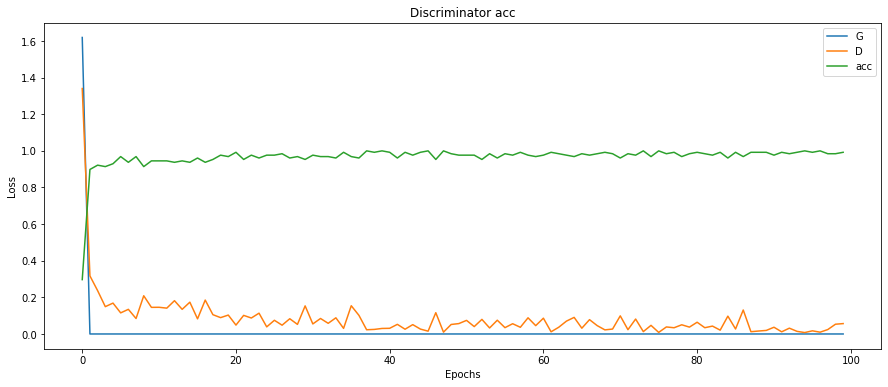

In [21]:
plt.figure(figsize=(15,6))
plt.plot(np.array(g_loss)[::1000], label='G')
plt.plot(np.array(d_loss)[::1000,0], label='D')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# plt.figure(figsize=(15,6))

# plt.plot(np.array(d_loss)[::100,0], label='acc')
plt.plot(np.array(d_loss)[::1000,1], label='acc')
plt.xlabel('Epochs')
plt.title('Discriminator acc')
plt.legend()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


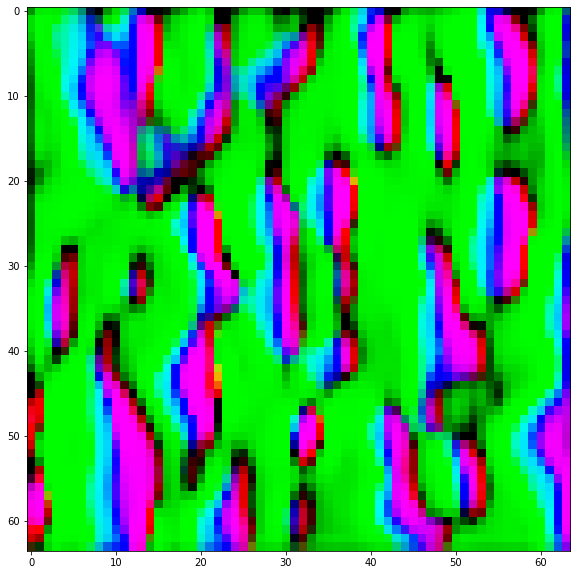

In [22]:
noise = np.random.normal(0, 1, (1, latent_dim))
gen_imgs = generator.predict(noise)
plt.figure(figsize=(10,10))
plt.imshow(gen_imgs[0])

In [ ]:
labels = to_categorical(y_valid, num_classes=3)
history = discriminator.evaluate(x_valid,labels, batch_size=64)

In [24]:
history

[1.1180260370019823, 0.7765198]

In [25]:
np.array(discriminator.predict(x_valid[:10])).argmax(axis=-1)

array([1, 0, 1, 1, 1, 1, 0, 1, 0, 1])

In [15]:
x_train[0,0,0]

array([0.38039216, 0.16078431, 0.4745098 ])

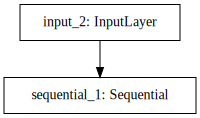

In [11]:
# SVG(model_to_dot(generator).create(prog='dot', format='svg'))

In [14]:
# x_train = h5py.File('camelyonpatch_level_2_split_train_x.h5', 'r')['x'][:, 16:80,16:80]/255.
# y_train = h5py.File('camelyonpatch_level_2_split_train_y.h5', 'r')['y'].value.reshape(-1,1)
# x_train = h5py.File('x_aug.h5', 'r')['x'].value
y_train = h5py.File('y_aug.h5', 'r')['y'].value
x_valid = h5py.File('camelyonpatch_level_2_split_valid_x.h5', 'r')['x'][:, 16:80,16:80]/255.
y_valid = h5py.File('camelyonpatch_level_2_split_valid_y.h5', 'r')['y'].value.reshape(-1,1)

# datagen = ImageDataGenerator(
# #     preprocessing_function=lambda x: x/255.,
#     rotation_range=180,
#     horizontal_flip=True,  # randomly flip images
#     vertical_flip=True)  # randomly flip images

# strategy = tf.distribute.MirroredStrategy()
# with strategy.scope():




In [32]:
x_train_10.shape

(2621, 64, 64, 3)

In [10]:
def bin_clf():
    kernel_size = 4
    model = Sequential()

    model.add(Conv2D(32, kernel_size=kernel_size, strides=2, 
                     input_shape=(64, 64, 3), padding="same"))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.15))

    model.add(Conv2D(64, kernel_size=kernel_size, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.15))

    model.add(Conv2D(128, kernel_size=kernel_size, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.15))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.15))

    model.add(Dense(2))    
    model.add(Activation('softmax'))
    model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(lr=0.0002, beta_1=0.5))  
    return model

In [157]:
def wasserstein_loss(y_true,y_pred):
    return K.mean(y_true*y_pred)

def create_critic_final(width, height, channels, kernel_size=4):
    """ Declare discriminator """

    model = Sequential()

    model.add(Conv2D(32, kernel_initializer=initializers.RandomNormal(mean=0,stddev=0.2), 
                     kernel_size=kernel_size, strides=2, 
                     input_shape=(width, height, channels), padding="same"))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.15))

    model.add(Conv2D(64, kernel_size=kernel_size, strides=2, padding="same",
             kernel_initializer=initializers.RandomNormal(mean=0,stddev=0.2)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.15))

    model.add(Conv2D(128, kernel_size=kernel_size, strides=2, padding="same",
             kernel_initializer=initializers.RandomNormal(mean=0,stddev=0.2)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.15))

    model.add(Flatten())
    model.add(Dense(256,
             kernel_initializer=initializers.RandomNormal(mean=0,stddev=0.2)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.15))

    model.add(Dense(1,
             kernel_initializer=initializers.RandomNormal(mean=0,stddev=0.2)))

    model.compile(loss=wasserstein_loss,optimizer=RMSprop(lr=0.00005), metrics=['accuracy'])
    
    return model

In [ ]:
model = create_critic_final(64,64,3)
y_w = np.full_like(y_train_small.astype(int), 1)
y_w[y_train_small==0] = -1


t_loss = []
v_loss = []

t_acc = []
v_acc = []

batch_size=128

for epoch in range(20):
    loss = []
    acc = []
    for idx in tqdm(np.array_split(shuffle(range(x_train_small.shape[0])), x_train_small.shape[0]/batch_size), desc="epoch "+str(epoch)):
        tl, ta = model.train_on_batch(x_train_small[idx],y_w[idx])
        loss.append(tl)
        acc.append(ta)
        
        weights = [np.clip(w, -0.01, 0.01) for w in model.get_weights()]
        model.set_weights(weights)
    
    loss_mean = sum(loss)/len(loss)
    acc_mean = sum(acc)/len(acc)
    
    t_loss.append(loss_mean)
    vl, va = model.evaluate(x_valid, y_valid, batch_size=batch_size, verbose=0)
    v_loss.append(vl)
    v_acc.append(va)
    print("loss: %.4f; acc: %.2f; v_loss: %.4f; v_acc: %.2f"%(loss_mean, acc_mean, vl, va))

    
plt.plot(t_acc)
plt.plot(v_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.figure()

plt.plot(t_loss)
plt.plot(v_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [ ]:
model = bin_clf()
# model = simple_clf(64,64,3, 2)
# model, discriminator, generator, gan = build(64, 64, 3, 100, 2)


batch_size = 128
# training_gen = crop_generator(datagen.flow(x_train, y_train, batch_size=batch_size))
# valid_gen = crop_generator(datagen.flow(x_valid, y_valid, batch_size=batch_size))

path = 'results/bin_clf_full_dataset'
if not os.path.exists(path):
    os.mkdir(path)
    
checkpoint = ModelCheckpoint(path+'/weights_best.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
csv_logger = CSVLogger(path+'/history_log.csv', append=False)
early = EarlyStopping(monitor='val_loss', patience=16)

history = model.fit(x_train, y_train, batch_size=batch_size,
#                     steps_per_epoch=100, validation_steps = 100,
                    validation_data=(x_valid,y_valid),
                    epochs=1000, callbacks=[checkpoint, csv_logger, early],
#                     workers = 6,use_multiprocessing=True
                   )



plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.figure()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')


model.save(path+'/model.h5')
model.save_weights(path+'/weights.h5')

In [172]:
model.load_weights(path+'/weights_best.h5')
model.evaluate(x_test, y_test)

32768/32768 [==============================] - 5s 145us/step


[0.6898416609728883, 0.77362060546875]

In [173]:
model.evaluate(x_valid, y_valid)

32768/32768 [==============================] - 5s 155us/step


[0.5716320445862948, 0.81243896484375]

In [175]:
pred_fake = model.predict(fake)

In [176]:
idx_fake = np.any(pred_fake>0.95, axis=1)
y_fake = np.argmax(pred_fake[idx_fake], axis=1).reshape(-1,1)
X_fake = fake[idx_fake]
y_fake.shape[0]

164817

array([1])

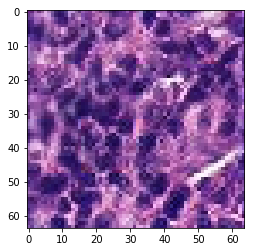

In [99]:
i = np.random.randint(X_fake.shape[0])
plt.imshow(X_fake[i]*.5+.5)

y_fake[i]

In [102]:
X_mixed = np.concatenate([x_train_small, X_fake])
y_mixed = np.concatenate([y_train_small, y_fake])
X_mixed.shape

(113897, 64, 64, 3)

Train on 164817 samples, validate on 32768 samples
Epoch 1/1000
164817/164817 [==============================] - 32s 192us/step - loss: 0.1674 - acc: 0.9352 - val_loss: 0.6334 - val_acc: 0.7885

Epoch 00001: val_acc improved from -inf to 0.78851, saving model to results/bin_clf_fake_full_ds_model/weights_best.h5
Epoch 2/1000
164817/164817 [==============================] - 30s 183us/step - loss: 0.0884 - acc: 0.9681 - val_loss: 0.6938 - val_acc: 0.7889

Epoch 00002: val_acc improved from 0.78851 to 0.78894, saving model to results/bin_clf_fake_full_ds_model/weights_best.h5
Epoch 3/1000
164817/164817 [==============================] - 26s 156us/step - loss: 0.0648 - acc: 0.9768 - val_loss: 1.0178 - val_acc: 0.7677

Epoch 00003: val_acc did not improve from 0.78894
Epoch 4/1000
164817/164817 [==============================] - 29s 177us/step - loss: 0.0504 - acc: 0.9817 - val_loss: 0.8289 - val_acc: 0.7977

Epoch 00004: val_acc improved from 0.78894 to 0.79773, saving model to results/bin

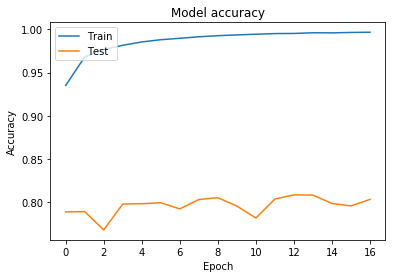

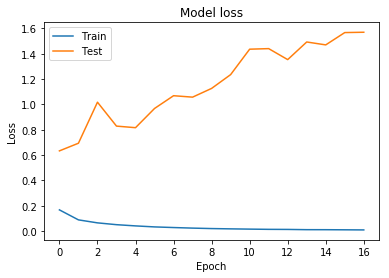

In [178]:
model_fake = bin_clf()

batch_size = 128

path = 'results/bin_clf_fake_full_ds_model'
if not os.path.exists(path):
    os.mkdir(path)
    
checkpoint = ModelCheckpoint(path+'/weights_best.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
csv_logger = CSVLogger(path+'/history_log.csv', append=False)
early = EarlyStopping(monitor='val_loss', patience=16)

history_fake = model_fake.fit(X_fake, y_fake, batch_size=batch_size,
#                     steps_per_epoch=100, validation_steps = 100,
                    validation_data=(x_valid,y_valid),
                    epochs=1000, callbacks=[checkpoint, csv_logger, early],
#                     workers = 6,use_multiprocessing=True
                   )



plt.plot(history_fake.history['acc'])
plt.plot(history_fake.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.figure()

plt.plot(history_fake.history['loss'])
plt.plot(history_fake.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')


model.save(path+'/model.h5')
model.save_weights(path+'/weights.h5')

In [179]:
model_fake.evaluate(x_test, y_test)

32768/32768 [==============================] - 5s 151us/step


[1.6031929167656926, 0.789947509765625]

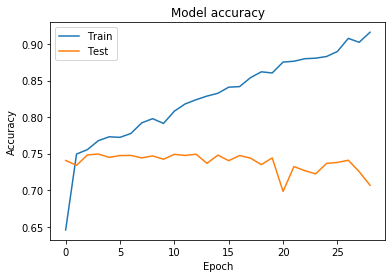

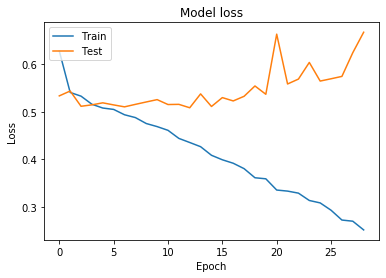

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.figure()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

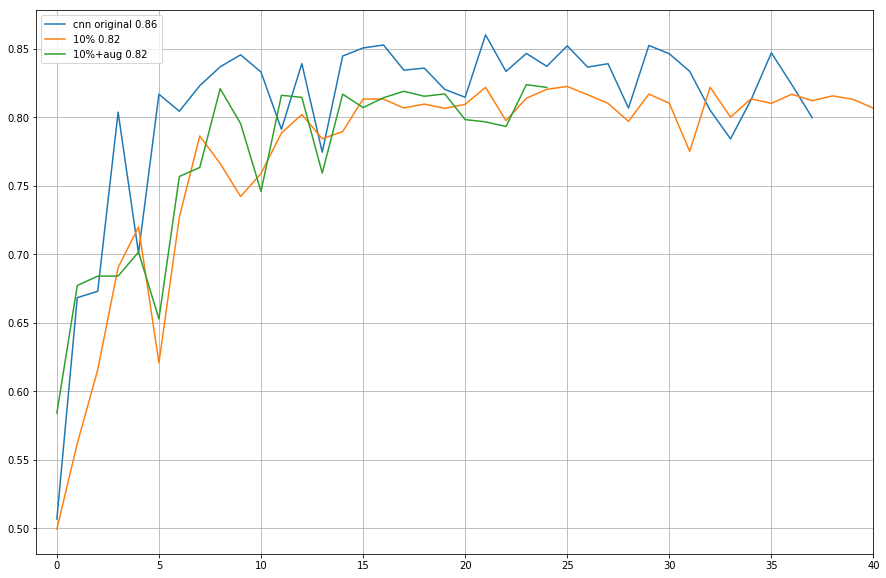

In [17]:
cnn = np.loadtxt('models/cnn_bn/cnn_bn_history.csv', delimiter=',', skiprows=1, usecols=3)
cnn10 = np.loadtxt('models/cnn_bn_10percent/cnn_bn_10percent_history.csv', delimiter=',', skiprows=1, usecols=3)[7::3]
cnn10_aug = np.loadtxt('models/cnn_bn_10percent_aug/cnn_bn_10percent_aug_history.csv', delimiter=',', skiprows=1, usecols=3)

plt.figure(figsize=(15,10))
plt.plot(cnn, label='cnn original {:0.2f}'.format(cnn.max()))
plt.plot(cnn10, label='10% {:0.2f}'.format(cnn10.max()))
plt.plot(cnn10_aug, label='10%+aug {:0.2f}'.format(cnn10_aug.max()))
plt.legend()
plt.xlim(-1,40)
plt.grid()

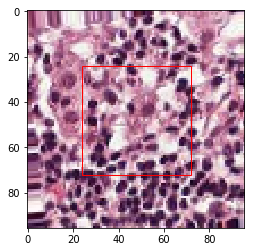

In [169]:
from matplotlib.patches import Rectangle

datagen = ImageDataGenerator(
              preprocessing_function=lambda x: x/255.,
    rotation_range=180,
#               horizontal_flip=True,  # randomly flip images
#               vertical_flip=True
)  # randomly flip images

img = datagen.flow(x_train[10:11])[0][0]
plt.imshow(img)
# Create a Rectangle patch
rect = Rectangle((24,24),48,48,linewidth=1,edgecolor='r',facecolor='none')
ax = plt.gca()
# Add the patch to the Axes
ax.add_patch(rect)

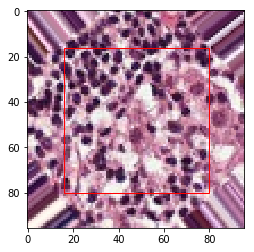

In [139]:
plt.imshow(img)
# Create a Rectangle patch
rect = Rectangle((16,16),64,64,linewidth=1,edgecolor='r',facecolor='none')
ax = plt.gca()
# Add the patch to the Axes
ax.add_patch(rect)

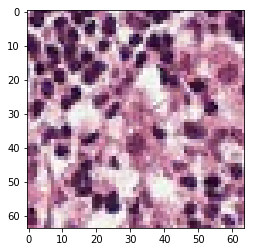

In [145]:
plt.imshow(img[16:16+64, 16:16+64])

16 80 16 80


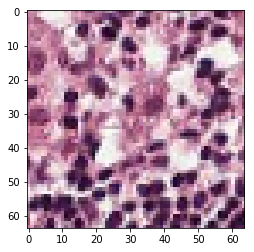

In [170]:
plt.imshow(center_crop(img, 64))

In [183]:
def center_crop(img, new_size):
    x,y,_ = img.shape
    x = x // 2
    y = y // 2
    size = new_size // 2
    return img[x-size:x+size, y-size:y+size]


def crop_generator(batches, new_size):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    while True:
        batch_x = next(batches)
        print(batch_x.shape)
#         batch_crops = np.zeros((batch_x.shape[0], new_size, new_size, 3))
#         for i in range(batch_x.shape[0]):
#             batch_crops[i] = center_crop(batch_x[i], new_size)
        yield (batches[:, 16:80,16:80, :])

(1, 64, 64, 3)


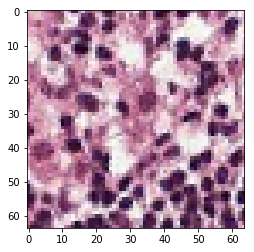

In [184]:
img = next(crop_generator(datagen.flow(x_train[10:11]), 64))[0]
plt.imshow(img)
